In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date # to handle datetime
import matplotlib.pyplot as plt

%pip install dython
from dython import nominal

import os
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


# Classification
We will classify cases based on the time it takes to close the cases.

Specifically, we will take rows where the 'date_of_decision' field is not null and calculate the number of days between this date and 'date_of_filing'. This will be the time it took to 'close' the case.

Using this we define the following categories:
- 1: closing time < 6 months (182 days)
- 2: 182 days <= closing time < 3 years (1095 days)
- 3: closing time >= 1095 days

# Reading the Data

In [4]:
# reading case_data
year = 2013
case_data = pd.read_csv('/kaggle/input/precog/cases/cases/cases_'+ str(year) + '.csv')

# Preprocessing
We delete all records with invalid/missing data.

Joining case data with acts_sections data.

In [5]:
# replacing invalid data with NaN

# returns NaN if the input date is out of bounds, else returns back the input
def correct_date(d):
    if((not isinstance(d, str)) or (len(d) != 10)):
        return np.NaN
    
    da = datetime(int(d[:4]), int(d[5:7]), int(d[8:]))
    if(datetime(2025, 12, 31) < da or da < datetime(year, 1, 1)):
        return np.NaN
    return d

# returns NaN if the input string or integer is equivalent to -9999(missing name) or -9998(name unclear 
def correct_fem(d):
    if(isinstance(d, str)):
        if((d == '1 female') or (d == '0 male')):
            return int(d[0])
        else:
            return np.NaN
    else:
        if(d == 0 or d == 1):
            return d
        else:
            return np.NaN
    
init_size = case_data.size

# Replace irregular data with NaN
case_data['date_of_decision'] = case_data['date_of_decision'].map(correct_date)
for i in ['female_defendant', 'female_adv_def', 'female_petitioner', 'female_adv_pet']:
    case_data[i] = case_data[i].map(correct_fem)
    
# dropping rows with NaN values in these columns
data = case_data.dropna(subset=['date_of_decision', 'female_defendant', 'court_no',
                                'type_name', 'judge_position', 'disp_name', 
                                'purpose_name'], axis=0)

# adding a month field
def retmonth(d):
    return int(d[5:7])
data['month_of_filing'] = data.date_of_filing.map(retmonth)

final_size = data.size
print("% dropped:", (1 - (final_size/init_size)) * 100)

% dropped: 32.47824415718935


In [6]:
data

,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list,month_of_filing
1,01-01-01-201908000012013,2013,1,1,1,MHNB030000112013,chief judicial magistrate,0.0,0.0,NaN,0.0,1919.0,7062.0,25,2013-01-01,2013-01-01,2013-01-01,2013-01-01,2013-01-01,1
3,01-01-01-201908000032013,2013,1,1,1,MHNB030000182013,chief judicial magistrate,0.0,1.0,NaN,0.0,1919.0,5148.0,25,2013-01-02,2013-08-12,2013-01-02,2013-07-24,2013-08-12,1
4,01-01-01-201908000042013,2013,1,1,1,MHNB030000202013,chief judicial magistrate,0.0,1.0,NaN,0.0,1919.0,5148.0,22,2013-01-02,2015-08-10,2013-02-13,2015-08-03,2015-08-10,1
5,01-01-01-201908000052013,2013,1,1,1,MHNB030000212013,chief judicial magistrate,0.0,0.0,NaN,0.0,1919.0,5148.0,25,2013-01-02,2013-01-02,2013-01-02,2013-01-02,2013-01-02,1
6,01-01-01-201908000062013,2013,1,1,1,MHNB030000312013,chief judicial magistrate,0.0,1.0,NaN,0.0,1919.0,5148.0,25,2013-01-04,2013-01-04,2013-01-04,2013-01-04,2013-01-04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555612,33-02-01-201000000022013,2013,33,2,1,LDLH010000012013,principal district and sessions court,0.0,NaN,0.0,0.0,5869.0,5148.0,4,2013-06-03,2018-03-31,2017-07-24,2018-03-31,2018-03-31,6
7555613,33-02-02-219800000012013,2013,33,2,2,LDLH020000062013,principal district judge,1.0,NaN,NaN,0.0,6400.0,754.0,24,2013-02-19,2019-12-24,2017-08-09,2019-12-24,2019-12-24,2
7555614,33-02-02-219800000032013,2013,33,2,2,LDLH020000012013,principal district judge,1.0,1.0,1.0,1.0,6400.0,7224.0,24,2013-03-08,2019-05-14,2017-08-02,2019-05-14,2019-05-14,3
7555615,33-02-02-224200000082013,2013,33,2,2,LDLH020000072013,principal district judge,0.0,0.0,0.0,0.0,6505.0,7224.0,15,2013-07-19,2018-07-24,2017-08-10,2018-07-24,2018-07-24,7


We calculate the closing time in days for all the cases in the 'data' dataframe.

In [7]:
# calculate closing time in days
def retDays(row):
    d1 = row.date_of_filing
    d2 = row.date_of_decision
    d_1 = datetime(int(d1[:4]), int(d1[5:7]), int(d1[8:]))
    d_2 = datetime(int(d2[:4]), int(d2[5:7]), int(d2[8:]))
    return (d_2 - d_1).days

data['closing_time'] = data[['date_of_filing', 'date_of_decision']].apply(retDays, axis='columns')

We now calculate the 'category' column base on the categories defined above.

In [8]:
# create a categories column
def ret_category(closing_time):
    if closing_time < 182:
        return 1
    elif 182 <= closing_time < 1095:
        return 2
    else:
        return 3
    
data['category'] = data.closing_time.map(ret_category)

# Splitting the Data

Here we select features and split the dataset for training and testing.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# select the features
features = ['female_defendant', 'court_no', 'type_name',
            'judge_position', 'disp_name', 'purpose_name',
            'month_of_filing']
X = data[features]
y = data['category']

# label encoding for changing strings to integers and normalising numeric data
label_encoder = preprocessing.LabelEncoder()
for i in features:
    X[i] = label_encoder.fit_transform(X[i])
y = label_encoder.fit_transform(y)

# split into training and testing set
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, train_size=0.6)

In [10]:
# ratio of training set : testing set
print(train_X.size, '/', val_X.size, '=', train_X.size/val_X.size,)

20355720 / 13570487 = 1.4999992262621082


Calculate the correlation matrix to see if we need to drop any redundant columns.

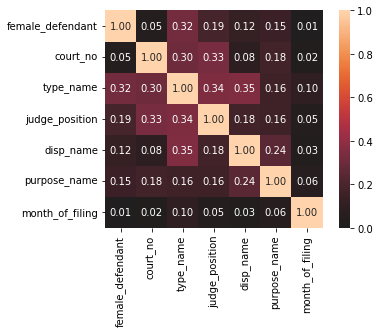

{'corr':                   female_defendant  court_no  type_name  judge_position  \
 female_defendant          1.000000  0.045573   0.316877        0.186974   
 court_no                  0.045573  1.000000   0.297220        0.333432   
 type_name                 0.316877  0.297220   1.000000        0.344272   
 judge_position            0.186974  0.333432   0.344272        1.000000   
 disp_name                 0.117812  0.078334   0.352806        0.175067   
 purpose_name              0.146922  0.177999   0.163563        0.160421   
 month_of_filing           0.011288  0.024306   0.099255        0.046145   
 
                   disp_name  purpose_name  month_of_filing  
 female_defendant   0.117812      0.146922         0.011288  
 court_no           0.078334      0.177999         0.024306  
 type_name          0.352806      0.163563         0.099255  
 judge_position     0.175067      0.160421         0.046145  
 disp_name          1.000000      0.242844         0.031761  
 purpose_n

In [11]:
nominal.associations(data[features], nominal_columns=features)

There are no features which have particularly high correlation therfore we can leave the features as is.

# Training Models
Train different models using the derived data.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 

cases_model = RandomForestClassifier(n_estimators=120, random_state=42)
cases_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=120, random_state=42)

In [13]:
predictions_val = cases_model.predict(val_X)
predictions_train = cases_model.predict(train_X)

# Performance Measures
We measure the performance of our models using 2 parameters: accuracy and confusion matrix.

In [14]:
from sklearn.metrics import accuracy_score

print('Accuracy of the model on training set: {:.3f}'
      .format(accuracy_score(train_y, predictions_train)))
print('Accuracy of the model on test set: {:.3f}'
      .format(accuracy_score(val_y, predictions_val)))

Accuracy of the model on training set: 0.852
Accuracy of the model on test set: 0.709


| Model Used | Accuracy on Training Set | Accuracy on Test Set |
| ---------- | ------------------------ | -------------------- |
|LogisticRegression        | 0.473 | 0.473 |
|DecisionTreeClassifier    | 0.852 | 0.694 |
|KNeighborsClassifier      | 0.764 | 0.671 |
|LinearDiscriminantAnalysis| 0.475 | 0.476 |
|GaussianNB                | 0.483 | 0.483 |
|RandomForestClassifier (10 trees)| 0.846 | 0.700 | ~100s to fit
|RandomForestClassifier (20 trees)| 0.851 | 0.704 |
|RandomForestClassifier (60 trees)| 0.852 | 0.708 | ~609s to fit
|RandomForestClassifier (120 trees)| 0.852 | 0.709 | ~1200s to fit

Text(0.5, 1.0, 'Confusion Matrix for Test Set')

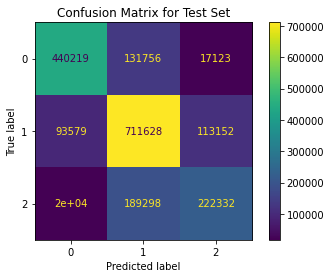

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = confusion_matrix(val_y, predictions_val)
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()
plt.title("Confusion Matrix for Test Set")

Text(0.5, 1.0, 'Confusion Matrix for Train Set')

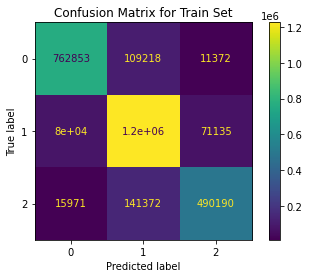

In [16]:
confusion_mat = confusion_matrix(train_y, predictions_train)
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()
plt.title("Confusion Matrix for Train Set")